<a href="https://colab.research.google.com/github/NachuanLi/demo/blob/master/high_way_simulation_crctupdate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy

In [2]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import copy

In [3]:
vic={"av":1, "pos":[0,3], "speed":130, "acceleration":0, "lane_change":-1, "aggressive":False, "route":1}
def initialization(av=1,ini_pos=[0,3],aggressive=False, route=1, lane_change=-1,lane_speed={1:100,2:120,3:130},plt_lane=[3], flow_rate=3000,av_rate=0.4, av_time_rate=0.9, max_plt_size=7, min_headway=1, plt_catchup_distance=100, forward=4, backward=2, min_inter_gap=5 ):
  #self
  self_lane=ini_pos[1]
  if self_lane in plt_lane:
    speed=lane_speed[self_lane]
  else:
    speed=np.random.normal(lane_speed[self_lane],5)
  self={"av":av, "pos":ini_pos, "speed":speed, "acceleration":0, "lane_change":lane_change, "aggressive":aggressive, "route":route}
  #{"av":1, "pos":[0,3], "speed":130, "acceleration":0, "lane_change":-1, "aggressive":False, "route":1}
  #flowrate perlane
  manual_flow=flow_rate*(1-av_rate)+flow_rate*av_rate*(1-av_time_rate)
  av_flow=flow_rate*av_rate*av_time_rate
  sum_manual_speed=0
  sum_plt_speed=0
  for lane in lane_speed:
    if not lane in plt_lane:
      sum_manual_speed+=lane_speed[lane]
    else:
      sum_plt_speed+=lane_speed[lane]
  
  
  lane_flow={}
  #plt_flow_rate={}
  for lane in lane_speed:
    if lane in plt_lane:
      lane_flow[lane]=av_flow*lane_speed[lane]/sum_plt_speed
    elif not lane in plt_lane:
      lane_flow[lane]=manual_flow*lane_speed[lane]/sum_manual_speed
  #random pltsize
  plt_size_list=[x for x in range(1, max_plt_size+1)]
  plt_prob={}
  cud=plt_catchup_distance/1000 #convert to km
  for lane in plt_lane:
    plt_prob_list=[]
    fr=lane_flow[lane]
    sp=lane_speed[lane]
    for s in plt_size_list:
      if s!=max_plt_size:
        plt_prob_list.append(((1-math.exp(-fr*cud/sp))**(s-1))*math.exp(-fr*cud/sp))
      elif s==max_plt_size:
        plt_prob_list.append(1-sum(plt_prob_list))
    plt_prob[lane]=plt_prob_list
  print(plt_prob)
  print(lane_flow)

  #start vehicle generation: forward and backward, on each lane
  veh_list={}
  x=ini_pos[0]
  y=ini_pos[1]
  for lane in lane_speed:
    fr=lane_flow[lane]
    veh_list[lane]=[]
    #print(fr)
    if not (lane in plt_lane):
      gap_f=0
      for i in range(forward):
        #if i=0 and lane!=x:

        spacing=max(np.random.exponential(1/fr)*(lane_speed[lane])*1000,5)
        gap_f+=spacing#need change##################################################
        #print("gapf"+str(spacing))
        veh_list[lane].append({"av":random.choices([0,1],[1-av_rate,av_rate*(1-av_time_rate)])[0], "pos":[x+gap_f,lane], "speed":np.random.normal(lane_speed[self_lane],5), "acceleration":0, "lane_change":0, "aggressive":aggressive, "route":route})
      gap_b=0
      for i in range(backward):
        spacing=max(np.random.exponential(1/fr)*(lane_speed[lane])*1000,5)
        gap_b+=spacing
        veh_list[lane].append({"av":random.choices([0,1],[1-av_rate,av_rate*(1-av_time_rate)])[0], "pos":[x-gap_b,lane], "speed":np.random.normal(lane_speed[self_lane],5), "acceleration":0, "lane_change":0, "aggressive":aggressive, "route":route})
    elif lane in plt_lane:
      ft=ini_pos[0]
      bk=ini_pos[0]
      veh_list[lane]=[]
    
      if y==lane:
        self_plt=[]
        self_plt_size=random.choices(plt_size_list, plt_prob[lane])[0]
        self_position=random.choices([k for k in range(1, self_plt_size+1)])[0]
        ft=x+(self_position-1)*min_headway/3600*lane_speed[lane]*1000
        bk=x+(self_position-self_plt_size)*min_headway/3600*lane_speed[lane]*1000
        for i in range(1, self_plt_size+1):
          posx=x+(self_position-i)*min_headway/3600*lane_speed[lane]*1000
          self_plt.append({"av":1, "pos":[posx,lane], "speed":lane_speed[lane], "acceleration":0, "lane_change":0, "aggressive":aggressive, "route":route})
      #fg=0
        veh_list[lane].append(self_plt)
      else:
        reference_plt=[]
        reference_plt_size=random.choices(plt_size_list,plt_prob[lane])[0]
        reference_pos=x+np.random.exponential(1/(fr/reference_plt_size))*lane_speed[lane]*1000   ##################################

        ft=reference_pos
        bk=reference_pos-(reference_plt_size)*min_headway*lane_speed[lane]/3.6
        for i in range(1,reference_plt_size+1):
          posx=reference_pos-(i-1)*min_headway*lane_speed[lane]/3.6
          reference_plt.append({"av":1, "pos":[posx,lane], "speed":lane_speed[lane], "acceleration":0, "lane_change":0, "aggressive":aggressive, "route":route})
        veh_list[lane].append(reference_plt)

      for i in range(forward//4):
        front_plt_size=random.choices(plt_size_list, plt_prob[lane])[0]
        platoon=[]
        ###########
        print("frontpltsize:"+str(front_plt_size))
        ft+=max(np.random.exponential(1/(fr/front_plt_size))*lane_speed[lane]*1000,(front_plt_size+min_inter_gap)*min_headway*lane_speed[lane]/3.6)################################################
        print("ft:"+str(ft))
        for num in range(front_plt_size):
          intra=num*min_headway*lane_speed[lane]/3.6
          

          platoon.append({"av":1, "pos":[ft-intra,lane], "speed":lane_speed[lane], "acceleration":0, "lane_change":0, "aggressive":aggressive, "route":route})
          

        
        veh_list[lane].append(platoon)
        
        back_plt_size=0
      for i in range(backward//4):
        threshold=back_plt_size+min_inter_gap
        back_plt_size=random.choices(plt_size_list, plt_prob[lane])[0]
        bk-=max(np.random.exponential(1/(fr/back_plt_size))*lane_speed[lane]*1000,threshold*min_headway*lane_speed[lane]/3.6)###########
        #back_plt_size=random.choices(plt_size_list, plt_prob[lane])[0]
        platoon=[]

        ################################################

        for num in range(back_plt_size):
          intra=num*min_headway/3600*lane_speed[lane]*1000
          platoon.append({"av":1, "pos":[bk-intra,lane], "speed":lane_speed[lane], "acceleration":0, "lane_change":0, "aggressive":aggressive, "route":route})
        
        veh_list[lane].append(platoon)
      
      xlst=[]
      ylst=[]
      n=[]
      m=[]
      for lane in veh_list:
        if type(veh_list[lane][0])==list:
          for platoon in veh_list[lane]:
            for veh in platoon:
              xlst.append(veh["pos"][0])
              ylst.append(veh["pos"][1])
              pass
        else:
          for veh in veh_list[lane]:
            #print(veh)
            xlst.append(veh["pos"][0])
            ylst.append(veh["pos"][1])

        plt.scatter(xlst,ylst)
        #plt.scatter([x],[y])

      return veh_list
      #print(veh_list[3])
      #for l in veh_list[2]:
        #print(len(l))
      
       


#initialization()

      
            

            


      












{3: [0.43571399276918776, 0.24586730927431996, 0.13873948225898927, 0.07828874848919516, 0.04417724529606522, 0.024928601358572822, 0.03228462055366976]}
{1: 872.7272727272727, 2: 1047.2727272727273, 3: 1080.0}
frontpltsize:1
ft:216.66666666666666


{1: [{'acceleration': 0,
   'aggressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [89.5111555529422, 1],
   'route': 1,
   'speed': 137.14595831222164},
  {'acceleration': 0,
   'aggressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [228.27239588326526, 1],
   'route': 1,
   'speed': 136.3486540275314},
  {'acceleration': 0,
   'aggressive': False,
   'av': 1,
   'lane_change': 0,
   'pos': [287.87343676007, 1],
   'route': 1,
   'speed': 125.47644083023013},
  {'acceleration': 0,
   'aggressive': False,
   'av': 1,
   'lane_change': 0,
   'pos': [314.35448566404284, 1],
   'route': 1,
   'speed': 123.51742305292244},
  {'acceleration': 0,
   'aggressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [-58.68693400042185, 1],
   'route': 1,
   'speed': 138.7808431241149},
  {'acceleration': 0,
   'aggressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [-67.55660341962924, 1],
   'route': 1,
   'speed': 138.1442373212758}],
 2: [{'acceleration': 0,
   'agg

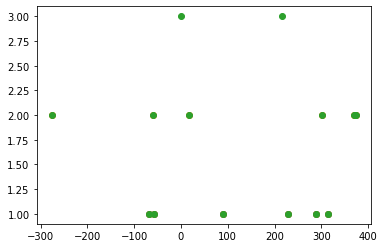

In [4]:
vl=initialization()
vl

{1: [{'av': 0, 'pos': [89.5111555529422, 1], 'speed': 137.14595831222164, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [228.27239588326526, 1], 'speed': 136.3486540275314, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [287.87343676007, 1], 'speed': 125.47644083023013, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [314.35448566404284, 1], 'speed': 123.51742305292244, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-58.68693400042185, 1], 'speed': 138.7808431241149, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-67.55660341962924, 1], 'speed': 138.1442373212758, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], 2: [{'av': 0, 'pos': [16.844939806663355, 2], 'speed': 131.29983862876955, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av

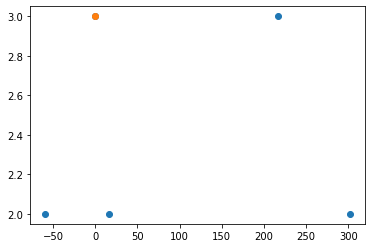

In [5]:
def get_nei(veh=vic,veh_list=vl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130}):
  x=veh["pos"][0]
  y=veh["pos"][1]
  nei_dic={1:{}, 0:{}, -1:{}}
  for i in [-1,0,1]:
    if y+i in lane_speed:
      if not (y+i in plt_lane):
        fv=None
        fp=1000000
        bv=None
        bp=-1000000
        soclose=[]
        print(veh_list)
        for veh in veh_list[y+i]:
          xpos=veh["pos"][0]
          if xpos<fp and xpos>x+min_headway*lane_speed[y+i]/3.6:
            fp=xpos
            fv=veh
          if xpos>bp and xpos<x-min_headway*lane_speed[y+i]/3.6:
            bp=xpos
            bv=veh
          if xpos>x-min_headway*lane_speed[y+i]/3.6 and xpos<x+min_headway*lane_speed[y+i]/3.6 and xpos!=x :
            soclose.append([veh,xpos-x])
        if bp!=-1000000: 
          nei_dic[i]["back"]=[bv,bp-x]
        if fp!=1000000:
          nei_dic[i]["front"]=[fv,fp-x]
        if soclose!=[]:
          nei_dic[i]["close"]=soclose

      elif y+i in plt_lane:
        fpos=100000
        fpos2=None
        bpos=-1000000
        bpos2=None
        fp=None
        bp=None
        soclose=[]
        for platoon in veh_list[y+i]:
          if type(platoon)==list:
            v_pos=[v["pos"][0] for v in platoon]
            plt_f=max(v_pos)
            plt_b=min(v_pos)
            if plt_b>x+min_headway*lane_speed[y+i]/3.6 and plt_f<fpos:
              fpos=plt_f
              fpos2=plt_b
              fp=platoon
            if plt_f<x-min_headway*lane_speed[y+i]/3.6 and plt_b>bpos:
              bpos=plt_f
              bpos2=plt_b
              bp=platoon
            if (plt_f>x and plt_b<x) or (plt_f<x+min_headway*lane_speed[y+i]/3.6 and plt_f>x-min_headway*lane_speed[y+i]/3.6) or (plt_b<x+min_headway*lane_speed[y+i]/3.6 and plt_b>x-min_headway*lane_speed[y+i]/3.6):
              soclose.append([platoon, plt_f-x, plt_b-x])
        if bpos2!=None:
          nei_dic[i]["back"]=[bp, bpos-x, bpos2-x]
        if fpos2!=None:
          nei_dic[i]["front"]=[fp, fpos-x, fpos2-x]
        if soclose!=[]:
          nei_dic[i]["close"]=soclose
  print(nei_dic)
  x_list=[]
  y_list=[]
  for key in nei_dic:
    if nei_dic[key]!={}:
      for a in nei_dic[key]:#a is back, front or close
        print(nei_dic[key][a]) 
        
        if type(nei_dic[key][a][0])==dict:
          x_list.append(nei_dic[key][a][0]["pos"][0])
          y_list.append(nei_dic[key][a][0]["pos"][1])
          #print(nei_dic[key][a])
        elif type(nei_dic[key][a][0])==list:
          if type(nei_dic[key][a][0][0])==dict:
            for v in nei_dic[key][a][0]:
              if type(v)==dict:
                x_list.append(v["pos"][0])
                y_list.append(v["pos"][1])
          elif type(nei_dic[key][a][0][0])==list:
            print(nei_dic[key][a][0])
            for k in nei_dic[key][a][0]:
              print("k")
              print(k)
              if type(k)==list:
                for v in k:
                  print("v")
                  print(v)
                  if type(v)==dict:
                    x_list.append(v["pos"][0])
                    y_list.append(v["pos"][1])
          
  plt.scatter(x_list,y_list)
  plt.scatter([x],[y])

  return nei_dic

nvl=get_nei()






{1: [{'av': 0, 'pos': [89.5111555529422, 1], 'speed': 137.14595831222164, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [228.27239588326526, 1], 'speed': 136.3486540275314, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [287.87343676007, 1], 'speed': 125.47644083023013, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [314.35448566404284, 1], 'speed': 123.51742305292244, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-58.68693400042185, 1], 'speed': 138.7808431241149, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-67.55660341962924, 1], 'speed': 138.1442373212758, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], 2: [{'av': 0, 'pos': [16.844939806663355, 2], 'speed': 131.29983862876955, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av

{-1: [True, 89.5111555529422, -58.68693400042185],
 0: [False, 16.844939806663355, -59.13111914113707],
 1: [False, 0, -10000]}

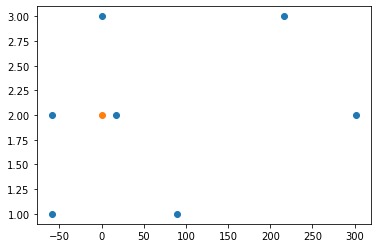

In [6]:
# no close vehicle 

vic={'av': 0, 'pos': [0, 2], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}
def gap_eval(veh=vic,veh_list=vl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130}):
  nvl=get_nei(veh=veh,veh_list=veh_list,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
  lane_change=veh["lane_change"]
  self_gap_safe=True
  left_change_possible=False
  right_change_possible=False
  frontgaps={-1:None,0:None,1:None}
  backgaps={-1:None,0:None,1:None}


  for key in nvl:
    
    if nvl[key]!={}:
      nei_pos=[] 
      if veh["pos"][1]+key in plt_lane:

        
        for k in nvl[key]:
          if k!="close":
            if nvl[key][k][2]>0 and nvl[key][k][1]>0:
              nei_pos.append(min(nvl[key][k][2],nvl[key][k][1]))
            elif nvl[key][k][2]<0 and nvl[key][k][1]<0:
              nei_pos.append(max(nvl[key][k][2],nvl[key][k][1]))
            else:
              nei_pos.append(0)
          else:
            #print(nvl)
            for p in nvl[key]["close"]:
              if p[1]>0 and p[2]>0:
                nei_pos.append(min(p[1],p[2]))
              elif p[1]<0 and p[2]<0:
                nei_pos.append(max(p[1],p[2]))
              else:
                nei_pos.append(0)

      elif not veh["pos"][1]+key in plt_lane:
        for k in nvl[key]:
          if k!="close":
            nei_pos.append(nvl[key][k][1])
          else:
            for p in nvl[key]["close"]:
              nei_pos.append(p[1])

      fgl=[g for g in nei_pos if g>=0]
      bgl=[g for g in nei_pos if g<0]
      try:
        frontgaps[key]=min(fgl)
      except:
        frontgaps[key]=10000
      try:
        backgaps[key]=max(bgl)
      except:
        backgaps[key]=-10000
      if key!=0:
        if not ("close" in nvl[key]):
          if key==-1 and lane_change!=1:
            right_change_possible=True
            
          if key==1 and lane_change!=-1:
            left_change_possible=True
            if veh["av"]==0 and veh["pos"][1]+lane_change in plt_lane:
              left_change_possible=False
      elif key==0:
        if frontgaps[key]<=lane_speed[veh["pos"][1]]/3.6*min_headway:
          self_gap_safe=False




  return {1:[left_change_possible,frontgaps[1],backgaps[1]],-1:[right_change_possible,frontgaps[-1],backgaps[-1]],0:[self_gap_safe, frontgaps[0],backgaps[0]]}

gap_eval()









In [7]:

def manual_speed_reduction(veh=vic,veh_list=vl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130}):
  x=veh["pos"][0]
  y=veh["pos"][1]
  print(veh_list)
  vidx=veh_list[y].index(veh)#what if not in 
  nv_list=get_nei(veh=veh,veh_list=veh_list,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
  same_lane_list=nv_list[0]
  veh["speed"]=np.random.normal(lane_speed[y],5)
  if not y in plt_lane:
    if ("close" in nv_list[0]):
      gp=gap_eval(veh=vic,veh_list=veh_list,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
      
      if gp[0][0]==False:#cls_lst[1]>x and cls[0]["speed"]<=veh["speed"]-5:
        print("speed reduction")
        veh["speed"]-=3
        veh_list[y][vidx]=veh
  return veh,veh_list
#manual_speed_reduction()



In [8]:
def lane_change(veh=vic, veh_list=vl, plt_lane=[3],lane_speed={1:120,2:120,3:130}):
  print(veh_list)
  print(len(veh_list[1]))
  print(len(veh_list[2]))
  #vidx=veh_list[veh["pos"][1]].index(veh)
  #veh_list[veh["pos"][1]].pop(vidx)
  #if not veh["pos"][1]
  veh["pos"][1]+=veh["lane_change"]
  #veh["pos"][0]+=veh["speed"]/3.6
  if veh["pos"][1] in plt_lane:
    veh["speed"]=lane_speed[veh["pos"][1]]
  else:
    if veh["lane_change"]!=0:
      veh["speed"]=np.random.normal(lane_speed[veh["pos"][1]],5)
  veh["lane_change"]=0
#  print(vidx)
  print(veh)
  #veh_list[veh["pos"][1]].append(veh)
  
  return veh#,veh_list
  
    

#lane_change()


In [9]:
def platoon_full(plt_lane=[3],veh_list=vl, lane_speed={1:120,2:120,3:130}, min_intra_space=5, min_headway=1):
  platoon_full={}
  for lane in plt_lane:
    veh_count=0
    plt_count=0
    min_pos=0
    max_pos=0
    for platoon in veh_list[lane]:
      plt_count+=1
      for veh in platoon:
        veh_count+=1
        if veh["pos"][0]>max_pos:
          max_pos=veh["pos"][0]
        if veh["pos"][0]<min_pos:
          min_pos=veh["pos"][0]
    distance=max_pos-min_pos
    print(max_pos)
    print(min_pos)
    print(veh_count)
    print(plt_count)
    average_spacing=distance/(veh_count+plt_count*min_intra_space+1)
    if average_spacing <min_headway*lane_speed[lane]/3.6:
      platoon_full[lane]=True
    else:
      platoon_full[lane]=False

  return platoon_full

platoon_full()



  

216.66666666666666
0
2
2


{3: True}

In [10]:
q={'av': 1, 'pos': [174, 3], 'speed': 5, 'acceleration': 0, 'lane_change': 1, 'aggressive': False, 'route': 1}
u={'av': 1, 'pos': [280, 3], 'speed': 5, 'acceleration': 0, 'lane_change': 1, 'aggressive': False, 'route': 1}
#will only assign individual vehicles in plt_lane with lane_change as 0
vl[3].append(q)
vl[3].append(u)
def join_platoon_old(veh_list=vl,plt_lane=[3],lane_speed={1:120,2:120,3:130},min_headway=1,inter_gap=5,max_acc=5):
    raw_list=copy.deepcopy(veh_list)
    for l in plt_lane:
      for c in veh_list[l]:
        if type(c)==dict and c["lane_change"]==0:
          print("this is veh list")
          print(veh_list)
          veh_list[l].pop(veh_list[l].index(c))
          cnei=get_nei(veh=c,veh_list=raw_list,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
          t_plt=None
          dist=1000
          for ps in cnei[0]:
            if ps!="close":
              if min(abs(cnei[0][ps][1]),abs(cnei[0][ps][2]))<dist:
                dist=min(cnei[0][ps][1],cnei[0][ps][2])
                t_plt=cnei[0][ps][0]
          #print("#########################tplt")
          print(t_plt)
          if t_plt!=None:
            idx=veh_list[l].index(t_plt)
            veh_list[l][idx].append(c)
          elif t_plt==None:
            veh_list[l].append([c])
    return c, veh_list 


#join_platoon()
#fertig

In [102]:
def join_platoon(veh_list=vl,plt_lane=[3],lane_speed={1:120,2:120,3:130},min_headway=1,inter_gap=5,max_acc=5,catch_dist=500):
    raw_list=copy.deepcopy(veh_list)
    new_v_list={}
    reference_v_list={}
    scatter_list={}
    for lane in lane_speed:
      if not lane in plt_lane:
        new_v_list[lane]=veh_list[lane]
        reference_v_list[lane]=veh_list[lane]
      elif lane in plt_lane:
        reference_v_list[lane]=[]
        scatter_list[lane]=[]
        for k in veh_list[lane]:
          if type(k) == list:
            reference_v_list[lane].append(k)
          elif type(k)==dict:
            scatter_list[lane].append(k)
    
    for lane in plt_lane:
      for v in scatter_list[lane]:
        if v["lane_change"]==0:
          cnei=get_nei(veh=v,veh_list=reference_v_list,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
          t_plt=None
          dist=copy.deepcopy(catch_dist)
          for ps in cnei[0]:
            if ps!="close":
              if min(abs(cnei[0][ps][1]),abs(cnei[0][ps][2]))<dist:
                dist=min(cnei[0][ps][1],cnei[0][ps][2])
                t_plt=cnei[0][ps][0]
          if t_plt!=None:
            for member in reference_v_list[lane]:
              if member == t_plt:
                print("；；；；；；；；；；；；；；；；；；；；；；；；；；")
                print("found target platoon")
                member.append(v)
          else:
            reference_v_list[lane].append([v])
    return reference_v_list
            


In [85]:
for k in []:
  print(k)

In [11]:
p=[{'av': 1, 'pos': [0.0, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [-5.11111111111111, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'agressive': False, 'route': 1}, {'av': 1, 'pos': [-122.22222222222221, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'agressive': False, 'route': 1}, {'av': 1, 'pos': [20, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'agressive': False, 'route': 1}]
vl={3:[p,[]]}
# applies to each plt lane
def pop_from_platoon(plt_list=p,veh_list=vl,lane=3, plt_lane=[3]):
  new_plt_list=[]
  changed_lane=[]
  #lc=veh["lane_change"]
  #print(veh["pos"])
  for k in plt_list:
        #thresh_p=-1000000
        #for vl in range(len(veh_list[lane][k])):
          #print(platoon)
    if type(k)==list:
        #print(veh["pos"])
        #print(veh_list[lane][k][vl]["pos"])
      k_list=[]
      for v in k:
        print(v)
        vic=lane_change_eval(veh=v,veh_list=veh_list,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000})
        print(vic)
        if vic["pos"][1]==lane:   
          k_list.append(vic)  
        else:
          changed_lane.append(vic)  
            #thresh_p=veh["pos"][0]
      if k_list!=[]:
        new_plt_list.append(k_list)

          #need to be adjusted for 2 lane of plt
  print("**********************^^^^^^^^^^^^^^^^^^^^^^^^^^")
  print(changed_lane)
  return new_plt_list,changed_lane


#pop_from_platoon()           
          





In [12]:
p=[{'av': 1, 'pos': [0.0, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [-5.11111111111111, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'agressive': False, 'route': 1}, {'av': 1, 'pos': [-122.22222222222221, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'agressive': False, 'route': 1}, {'av': 1, 'pos': [20, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'agressive': False, 'route': 1}]
vl={3:[p,[]]}
#for plt in plt_lane
def update_plt(platoon=[], veh_list=vl,plt_lane=[3],min_headway=1,permutation=5, speed_increment=2):
  raw_list=veh_list#may need to be in argument
  if platoon==[]:
    print("end platoon")
    for l in plt_lane:
      try:
        print(veh_list[l].index([]))
        veh_list[l].pop(veh_list[l].index([]))
      except:
        pass
  elif type(platoon)==list:
    print(platoon)
    p_lane=platoon[0]["pos"][1]
    index=veh_list[p_lane].index(platoon)
    sorted_plt=sorted(platoon, key = lambda i: i['pos'][0], reverse=True)
    speed=sorted_plt[0]["speed"]
    acc_pos_list=[]
    dec_pos_list=[]
    dec_zone=False
    acc_zone=False
    for idx in range(1,len(sorted_plt)):
      if sorted_plt[idx]["pos"][0]<sorted_plt[idx-1]["pos"][0]-min_headway*speed/3.6-permutation: #and sorted_plt[idx]["speed"]<sorted_plt[idx-1]["speed"]+5:
        acc_zone=True
        dec_zone=False

      if sorted_plt[idx]["pos"][0]>sorted_plt[idx-1]["pos"][0]-min_headway*speed/3.6+permutation: #and sorted_plt[idx]["speed"]>sorted_plt[idx-1]["speed"]+5:
        acc_zone=False
        dec_zone=True
      if acc_zone==True and dec_zone==False:
        acc_pos_list.append(sorted_plt[idx]["pos"][0])
      if acc_zone==False and dec_zone==True:
        dec_pos_list.append(sorted_plt[idx]["pos"][0])
      print(sorted_plt[idx-1]["pos"][0]-sorted_plt[idx]["pos"][0])
    print(acc_pos_list)
    print("that was acc")
    print(dec_pos_list)
    print("that was dec")
    print(platoon)
    print("that was orig plt")
    for i in range(len(platoon)):
      platoon[i]["speed"]=sorted_plt[0]["speed"]
      if platoon[i]["pos"][0] in acc_pos_list: #and platoon[i-1]["speed"]>=platoon[i]["speed"]: # and platoon[i]["s"]<135:
        #platoon[i]["acceleration"]=5
        platoon[i]["speed"]+=speed_increment
      
      if platoon[i]["pos"][0] in dec_pos_list: #and platoon[i-1]["speed"]<=platoon[i]["speed"]: # and platoon[i]["speed"]>115:
        platoon[i]["speed"]-=speed_increment
  
    veh_list[p_lane][index]=platoon
 
  return platoon, veh_list
    

m=update_plt()#,key = lambda i: i["pos"][0])
m    
    
    
      
  


  

end platoon
1


([],
 {3: [[{'acceleration': 0,
     'aggressive': False,
     'av': 1,
     'lane_change': 0,
     'pos': [0.0, 3],
     'route': 1,
     'speed': 130},
    {'acceleration': 0,
     'agressive': False,
     'av': 1,
     'lane_change': 0,
     'pos': [-5.11111111111111, 3],
     'route': 1,
     'speed': 130},
    {'acceleration': 0,
     'agressive': False,
     'av': 1,
     'lane_change': 0,
     'pos': [-122.22222222222221, 3],
     'route': 1,
     'speed': 130},
    {'acceleration': 0,
     'agressive': False,
     'av': 1,
     'lane_change': 0,
     'pos': [20, 3],
     'route': 1,
     'speed': 130}]]})

In [13]:
p=[{'av': 1, 'pos': [0.0, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [-5.11111111111111, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'agressive': False, 'route': 1}, {'av': 1, 'pos': [-122.22222222222221, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'agressive': False, 'route': 1}, {'av': 1, 'pos': [20, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'agressive': False, 'route': 1}]
vl={3:[p,[]],2:[{'av': 1, 'pos': [0.0, 2], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}]}
def samelane_evolution(veh_list=vl, plt_lane=[3],t=1):
  for lane in veh_list:
    if not lane in plt_lane:
      for i in range(len(veh_list[lane])):
        print(i)
        print(veh_list[lane][i])
        new_posy=veh_list[lane][i]["pos"][1]
        new_posx=veh_list[lane][i]['pos'][0]+t*veh_list[lane][i]['speed']/3.6+(1/2)*veh_list[lane][i]["acceleration"]*t**2
        veh_list[lane][i]["pos"]=[new_posx,new_posy]
        veh_list[lane][i]["speed"]=veh_list[lane][i]["speed"]+veh_list[lane][i]["acceleration"]*t/3.6
    elif lane in plt_lane:
      for i in range(len(veh_list[lane])):
        if len(veh_list[lane][i])!=0:
          for ii in range(len(veh_list[lane][i])):
            new_posy=veh_list[lane][i][ii]["pos"][1]
            new_posx=veh_list[lane][i][ii]['pos'][0]+t*veh_list[lane][i][ii]['speed']/3.6+(1/2)*veh_list[lane][i][ii]["acceleration"]*t**2
            veh_list[lane][i][ii]["pos"]=[new_posx,new_posy]
            veh_list[lane][i][ii]["speed"]=veh_list[lane][i][ii]["speed"]+veh_list[lane][i][ii]["acceleration"]*t/3.6
   

  return veh_list

samelane_evolution()

0
{'av': 1, 'pos': [0.0, 2], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}


{2: [{'acceleration': 0,
   'aggressive': False,
   'av': 1,
   'lane_change': 0,
   'pos': [36.11111111111111, 2],
   'route': 1,
   'speed': 130.0}],
 3: [[{'acceleration': 0,
    'aggressive': False,
    'av': 1,
    'lane_change': 0,
    'pos': [36.11111111111111, 3],
    'route': 1,
    'speed': 130.0},
   {'acceleration': 0,
    'agressive': False,
    'av': 1,
    'lane_change': 0,
    'pos': [30.999999999999996, 3],
    'route': 1,
    'speed': 130.0},
   {'acceleration': 0,
    'agressive': False,
    'av': 1,
    'lane_change': 0,
    'pos': [-86.11111111111111, 3],
    'route': 1,
    'speed': 130.0},
   {'acceleration': 0,
    'agressive': False,
    'av': 1,
    'lane_change': 0,
    'pos': [56.11111111111111, 3],
    'route': 1,
    'speed': 130.0}],
  []]}

In [14]:
#platoon continuous demo
import matplotlib.pyplot as plt
count=0
for i in range(0,200):
  count+=1
  m1=update_plt(platoon=m, plt_lane=[3],min_headway=1,permutation=3)
  newm=[]
  for vehi in m1:
    newm.append(samelane_evolution(veh=vehi,t=1))
    #print(newm)
  print(m1)
  x=[v["pos"][0] for v in m1]
  y=[v["pos"][1] for v in m1]
  s=m1[0]["speed"]
  b=True
  for v in m1:
    if v!=s:
      b=False
  if b:
    break
  print(count)

  


  m1=newm
plt.scatter(x,y)

TypeError: ignored

In [ ]:
'''
# initialization, returns the vehicle network in terms of dic
initialization(av=1,ini_pos=[0,3],aggressive=False, route=1, lane_change=-1,lane_speed={1:100,2:120,3:130},plt_lane=[3], flow_rate=3000,av_rate=0.4, av_time_rate=0.9, max_plt_size=7, min_headway=1, plt_catchup_distance=100, forward=21, backward=14, min_inter_gap=5 ):
# returns the dic of neighboring vehicles (-1,1,0), for each there is front, back and so close
get_nei(veh=vic,veh_list=vl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
# if efg. -1:[safe or unsafe, frontgap, backgap]
gap_eval(veh=vic,veh_list=vl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
# reduce speed based on condition on the front vehicles, and changes deceleration, and speed (need to think more about this)
manual_speed_reduction(veh=vic,nv_list=nvl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
# returns a vehicle info after a lane change, including pos and speed
lane_change(veh=vic, plt_lane=[3],lane_speed={1:120,2:120,3:130})
# returns if a platoon is full in terms of a boolean value
platoon_full(plt_lane=[3],veh_list=vl, lane_speed={1:120,2:120,3:130}, min_intra_space=5, min_headway=1)
# returns veh_list, veh, which are the new vehile network dic and the new vehicle dic after exit
pop_from_platoon(veh_list=vl, veh=vic, plt_lane=[3])
# returns the new vehicle network after the platoon joning maneuver
join_platoon(veh=q, veh_list=vl,plt_lane=[3],lane_speed={1:120,2:120,3:130},min_headway=1,inter_gap=5,max_acc=5)
# returns the new platoon after intra platoon maneuver after a certain period of time
update_plt(platoon=p, plt_lane=[3],min_headway=1,permutation=2)
# returns the evolution of a vehicle based on simple lane keeping
samelane_evolution(veh={'av': 1, 'pos': [0.0, 3], 'speed': 130, 'acceleration': 2, 'lane_change': 0, 'aggressive': False, 'route': 1}, t=1)
'''
#note: all functions that returns veh should also return the new veh_list

In [15]:
def fastlane_rule(veh={'av': 1, 'pos': [0, 2], 'speed': 130.0, 'acceleration': 0, 'lane_change': 0, 'aggressive': True, 'route': 1},veh_list=vl,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000}):
  av=veh["av"]
  rt=veh["route"]
  x=veh["pos"][0]
  y=veh["pos"][1]
  agg=veh["aggressive"]
  nei=get_nei(veh=veh,veh_list=veh_list,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
  gaps=gap_eval(veh=veh, veh_list=veh_list,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
  for lc in gaps:
    if y+lc in plt_lane:
      gaps[lc][0]==False
  possible_lc={}
  
  for lc in gaps:
    if gaps[lc][0]==True or lc==0:
      possible_lc[lc]=gaps[lc][1]
  fastest_key=0
  max_g=0
  for key in possible_lc:
    if possible_lc[key]>max_g:
      max_g=possible_lc[key]
      fastest_key=key


  if agg==True:
    print(str(fastest_key)+"+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print(gaps)
    if not (gaps[-1][0]==False and gaps[0][0]==False and gaps[1][0]==False):
      #print(str(fastest_key)+"+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
      veh["lane_change"]=fastest_key
      veh=lane_change(veh=veh, veh_list=veh_list, plt_lane=[3],lane_speed={1:120,2:120,3:130})
    #else:
      #manual_speed_reduction()
  elif agg==False:
    if gaps[0][0]==False:
      if len(possible_lc)>1:
        veh["lane_change"]=fastest_key
        veh=lane_change(veh=veh, veh_list=veh_list, plt_lane=[3],lane_speed={1:120,2:120,3:130})
  #print("veh")
  #print(fastest_key)
  #print(veh)
  return veh


#fastlane_rule()
  


In [16]:
# finish lane change and assign lane_change back to 0
def right_priority(veh={'av': 1, 'pos': [0, 2], 'speed': 130.0, 'acceleration': 0, 'lane_change': 0, 'aggressive': True, 'route': 1},veh_list=vl,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000}):
   av=veh["av"]
   rt=veh["route"]
   x=veh["pos"][0]
   y=veh["pos"][1]
   #agg=veh["aggressive"]
   print("VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV")
   print(veh_list)
   nei=get_nei(veh=veh,veh_list=veh_list,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
   gaps=gap_eval(veh=veh, veh_list=veh_list,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
   if gaps[-1][0]==True:
     veh["lane_change"]=-1
     veh=lane_change(veh=veh, veh_list=veh_list, plt_lane=[3],lane_speed={1:120,2:120,3:130})
   return veh

def left_priority(veh={'av': 1, 'pos': [0, 2], 'speed': 130.0, 'acceleration': 0, 'lane_change': 0, 'aggressive': True, 'route': 1},veh_list=vl,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000}):
  av=veh["av"]
  rt=veh["route"]
  x=veh["pos"][0]
  y=veh["pos"][1]
  #agg=veh["aggressive"]
  nei=get_nei(veh=veh,veh_list=veh_list,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
  gaps=gap_eval(veh=veh, veh_list=veh_list,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
  if gaps[1][0]==True:
    veh["lane_change"]=1
    veh=lane_change(veh=veh, veh_list=veh_list, plt_lane=[3],lane_speed={1:120,2:120,3:130})
  return veh
  

def platoon_side_rule(veh={'av': 1, 'pos': [0, 2], 'speed': 130.0, 'acceleration': 0, 'lane_change': 0, 'aggressive': True, 'route': 1},veh_list=vl,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000}):
   rp=min(plt_lane)
   lp=max(plt_lane)
   y=veh["pos"][1]
   x=veh["pos"][0]
   if y>max(plt_lane):
     veh=right_priority(veh=veh,veh_list=veh_list,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000})
   elif y<min(plt_lane):
     veh=left_priority(veh=veh,veh_list=veh_list,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000})
   return veh



In [17]:
def lane_change_eval(veh={'av': 1, 'pos': [0, 3], 'speed': 130.0, 'acceleration': 0, 'lane_change': -1, 'aggressive': False, 'route': 1},veh_list=vl,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000}):
   av=veh["av"]
   rt=veh["route"]
   x=veh["pos"][0]
   y=veh["pos"][1]
   if rt!=0:
     exit_pos1=exit_pos[rt]
   else:
     exit_pos1=1000000
     print(exit_pos)
   platoon_join_position_list=[[exit_pos[key]+interchange_len, exit_pos[key]+interchange_len+lane_change_pos] for key in exit_pos]
   platoon_join_position_list.append([0,0+lane_change_pos])
   if av==0:
     if rt==0 or x+lane_change_pos+np.random.normal(0,10)<exit_pos1 or x+min_lane_change_pos>exit_pos1:
       print("`````````````````````````Yes`````````````````````````````")
       print(veh)
       veh=fastlane_rule(veh=veh,veh_list=veh_list,plt_lane=plt_lane,lane_speed=lane_speed,lane_change_pos=lane_change_pos,min_lane_change_pos=min_lane_change_pos, interchange_len=interchange_len, exit_pos=exit_pos)
     else:
       veh=right_priority(veh=veh,veh_list=veh_list,plt_lane=plt_lane,lane_speed=lane_speed,lane_change_pos=lane_change_pos,min_lane_change_pos=min_lane_change_pos, interchange_len=interchange_len, exit_pos=exit_pos)
   elif av==1:
     in_join=False
     in_leave=False
     if not y in plt_lane:
       for r in platoon_join_position_list:
         if x<r[1] and x>r[0]:
           in_join=True
       if in_join==True:
         veh=platoon_side_rule(veh=veh,veh_list=veh_list,plt_lane=plt_lane,lane_speed=lane_speed,lane_change_pos=lane_change_pos,min_lane_change_pos=min_lane_change_pos, interchange_len=interchange_len, exit_pos=exit_pos)
       elif x>exit_pos1-lane_change_pos and x<exit_pos1:
         veh=right_priority(veh=veh,veh_list=veh_list,plt_lane=plt_lane,lane_speed=lane_speed,lane_change_pos=lane_change_pos,min_lane_change_pos=min_lane_change_pos, interchange_len=interchange_len, exit_pos=exit_pos)
       else:
        #print(veh_list)
         veh=fastlane_rule(veh=veh,veh_list=veh_list,plt_lane=plt_lane,lane_speed=lane_speed,lane_change_pos=lane_change_pos,min_lane_change_pos=min_lane_change_pos, interchange_len=interchange_len, exit_pos=exit_pos)
     elif y in plt_lane:
       if x+lane_change_pos>=exit_pos1 and x+min_lane_change_pos<exit_pos1:
         veh=right_priority(veh=veh,veh_list=veh_list,plt_lane=plt_lane,lane_speed=lane_speed,lane_change_pos=lane_change_pos,min_lane_change_pos=min_lane_change_pos, interchange_len=interchange_len, exit_pos=exit_pos)
       else:
         veh=veh
   return veh








In [ ]:
ef=[1,2,3,4]
for k in range(len(ef)):
  print(k)

In [ ]:
import copy
tv=[1,2,3,4]
#tv=copy.copy(tu)
ta=copy.copy(tv)
ta.append(5)
tv

In [112]:
test=ntest#initialization(av=1,ini_pos=[0,3],aggressive=False, route=1, lane_change=-1,lane_speed={1:100,2:120,3:130},plt_lane=[3], flow_rate=3000,av_rate=0.4, av_time_rate=0.9, max_plt_size=7, min_headway=1, plt_catchup_distance=100, forward=4, backward=2, min_inter_gap=5 )
ntest=copy.deepcopy(test)
#{1: [{'av': 0, 'pos': [202.67886162850908, 1], 'speed': 139.31267260811532, 'acceleration': 0, 'lane_change': 0, 'aggressive': True, 'route': 0}, {'av': 0, 'pos': [236.23255420778491, 1], 'speed': 135.1332522657296, 'acceleration': 0, 'lane_change': 0, 'aggressive': True, 'route': 0}, {'av': 0, 'pos': [249.25849330030564, 1], 'speed': 128.2599585606223, 'acceleration': 0, 'lane_change': 0, 'aggressive': True, 'route': 0}, {'av': 0, 'pos': [298.55947888457877, 1], 'speed': 133.01023073526858, 'acceleration': 0, 'lane_change': 0, 'aggressive': True, 'route': 1}, {'av': 0, 'pos': [323.53830845085054, 1], 'speed': 130.44947264769937, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [350.8830242648957, 1], 'speed': 125.24745806838499, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [560.0931092113333, 1], 'speed': 123.40230357768515, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [565.897255704932, 1], 'speed': 123.49744342532429, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-111.94817168345548, 1], 'speed': 124.51992071116615, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-713.1242592434525, 1], 'speed': 123.69268363101409, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-724.5365122438017, 1], 'speed': 125.77048005718824, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-903.9653215575406, 1], 'speed': 133.27233513957069, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], 2: [{'av': 0, 'pos': [538.4820768620516, 2], 'speed': 130.93323165194843, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [557.0282573644002, 2], 'speed': 130.22800349416016, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [746.1059688477727, 2], 'speed': 122.63137978223955, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [941.2165417435098, 2], 'speed': 132.34540879616142, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [1090.2181290442902, 2], 'speed': 131.9702062696695, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [1170.659640580595, 2], 'speed': 133.26355435778203, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [1403.063665707306, 2], 'speed': 132.66624880089796, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [1460.3188137553288, 2], 'speed': 130.0021585506747, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-27.405783893994037, 2], 'speed': 128.7499462724667, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-148.7820826643822, 2], 'speed': 130.34362902429274, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-213.1191495086403, 2], 'speed': 129.9253067299706, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-363.39441913995387, 2], 'speed': 133.72237997297734, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], 3: [[{'av': 1, 'pos': [0.0, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], [{'av': 1, 'pos': [216.66666666666666, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], [{'av': 1, 'pos': [557.6538350454373, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [521.5427239343262, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [485.43161282321506, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], [{'av': 1, 'pos': [-244.91214969551044, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}]]}
#test=ntest
for key in test:
  if key==1 or key==2:
    for i in range(len(test[key])):
      test[key][i]['route']=0
def simulate_network(period=1, runs=1,plt_lane=[3],lane_speed={1:120,2:120,3:130},test=test):#,test1=copy.copy(test)):#,raw_veh_list=copy.copy(test)):
  vl=test
  for pe in range(period):
    #qv=vl
    raw_veh_list=copy.deepcopy(vl)
    new_list={}
    r={}
    for l_speed in lane_speed:
      new_list[l_speed]=[]
    for lane in raw_veh_list:
      r[lane]=len(raw_veh_list[lane]) 
    #all lane changes
    for lane in vl:
      print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&"+str(lane))
      if not lane in plt_lane:
        if not len(vl[lane])==0:
          for v in range(r[lane]):
            if len(test[lane])!=r[lane]:
              a=True
            temp_veh_list=copy.copy(raw_veh_list)
            new_idx=vl[lane].index(raw_veh_list[lane][v])
            
            #vl[lane][new_idx]
            new_veh=(lane_change_eval(veh=vl[lane][new_idx],veh_list=temp_veh_list,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000}))
            new_list[new_veh["pos"][1]].append(new_veh)
      
      
      elif lane in plt_lane:
        new_temp=copy.copy(raw_veh_list)
        #print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
        #print(new_temp[3])
        plt_lane=pop_from_platoon(plt_list=new_temp[lane],veh_list=new_temp,lane=3, plt_lane=[3])[0]
        #print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
        #print(plt_lane)
        a2m=pop_from_platoon(plt_list=new_temp[lane],veh_list=new_temp,lane=3, plt_lane=[3])[1]
        print(a2m)
        #pop_from_platoon(plt_list=p,veh_list=vl,lane=3, plt_lane=[3])
        for itm in plt_lane:
          new_list[lane].append(itm)
        for vic in a2m:
          new_list[vic["pos"][1]].append(vic)
        #for i in range(len(new_list))
        new_list=join_platoon(veh_list=new_list,plt_lane=[3],lane_speed={1:120,2:120,3:130},min_headway=1,inter_gap=5,max_acc=5,catch_dist=500)
        print("new_list")
        print(new_list)
        print("new_list")
        for pl in range(len(new_list[lane])):
          new_list=update_plt(platoon=new_list[lane][pl], veh_list=new_list,plt_lane=[3],min_headway=1,permutation=5, speed_increment=2)[1]
        #for i in range(len(vl[lane])):


          #if type(vl[lane][i])==dict and vl[lane][i]["lane_change"]!=0:
            #new_veh=(lane_change_eval(veh=vl[lane][new_idx],veh_list=temp_veh_list,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000}))
            #new_list=[new_veh["pos"][1]].append(new_veh)
          #else:
  
  return new_list#,raw_veh_list

new_list=simulate_network()
new_list



&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&1
{1: 1000, 2: 4000, 3: 7000}
`````````````````````````Yes`````````````````````````````
{'av': 0, 'pos': [23.21445668415635, 1], 'speed': 131.5895223929193, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 0}
{1: [{'av': 0, 'pos': [23.21445668415635, 1], 'speed': 131.5895223929193, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 0}, {'av': 0, 'pos': [288.07044506625823, 1], 'speed': 125.21801942825051, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 0}, {'av': 0, 'pos': [565.4162753973126, 1], 'speed': 130.69570837711368, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 0}, {'av': 0, 'pos': [604.812844819272, 1], 'speed': 128.62451820069955, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 0}, {'av': 0, 'pos': [-63.287442050292036, 1], 'speed': 133.87103949562368, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 0}, {'av': 0, 'pos': [-121.67448

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f7123d28840> (for post_execute):


KeyboardInterrupt: ignored

In [117]:
for i in range(0,1000): 
      
  test=initialization(av=1,ini_pos=[0,3],aggressive=False, route=1, lane_change=-1,lane_speed={1:100,2:120,3:130},plt_lane=[3], flow_rate=3000,av_rate=0.4, av_time_rate=0.9, max_plt_size=7, min_headway=1, plt_catchup_distance=100, forward=4, backward=2, min_inter_gap=5 )
  ntest=copy.deepcopy(test)
  #{1: [{'av': 0, 'pos': [202.67886162850908, 1], 'speed': 139.31267260811532, 'acceleration': 0, 'lane_change': 0, 'aggressive': True, 'route': 0}, {'av': 0, 'pos': [236.23255420778491, 1], 'speed': 135.1332522657296, 'acceleration': 0, 'lane_change': 0, 'aggressive': True, 'route': 0}, {'av': 0, 'pos': [249.25849330030564, 1], 'speed': 128.2599585606223, 'acceleration': 0, 'lane_change': 0, 'aggressive': True, 'route': 0}, {'av': 0, 'pos': [298.55947888457877, 1], 'speed': 133.01023073526858, 'acceleration': 0, 'lane_change': 0, 'aggressive': True, 'route': 1}, {'av': 0, 'pos': [323.53830845085054, 1], 'speed': 130.44947264769937, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [350.8830242648957, 1], 'speed': 125.24745806838499, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [560.0931092113333, 1], 'speed': 123.40230357768515, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [565.897255704932, 1], 'speed': 123.49744342532429, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-111.94817168345548, 1], 'speed': 124.51992071116615, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-713.1242592434525, 1], 'speed': 123.69268363101409, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-724.5365122438017, 1], 'speed': 125.77048005718824, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-903.9653215575406, 1], 'speed': 133.27233513957069, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], 2: [{'av': 0, 'pos': [538.4820768620516, 2], 'speed': 130.93323165194843, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [557.0282573644002, 2], 'speed': 130.22800349416016, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [746.1059688477727, 2], 'speed': 122.63137978223955, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [941.2165417435098, 2], 'speed': 132.34540879616142, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [1090.2181290442902, 2], 'speed': 131.9702062696695, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [1170.659640580595, 2], 'speed': 133.26355435778203, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [1403.063665707306, 2], 'speed': 132.66624880089796, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [1460.3188137553288, 2], 'speed': 130.0021585506747, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-27.405783893994037, 2], 'speed': 128.7499462724667, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-148.7820826643822, 2], 'speed': 130.34362902429274, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-213.1191495086403, 2], 'speed': 129.9253067299706, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-363.39441913995387, 2], 'speed': 133.72237997297734, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], 3: [[{'av': 1, 'pos': [0.0, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], [{'av': 1, 'pos': [216.66666666666666, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], [{'av': 1, 'pos': [557.6538350454373, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [521.5427239343262, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [485.43161282321506, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], [{'av': 1, 'pos': [-244.91214969551044, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}]]}
  #test=ntest
  for key in test:
    if key==1 or key==2:
      for i in range(len(test[key])):
        test[key][i]['route']=0
  def simulate_network(period=1, runs=1,plt_lane=[3],lane_speed={1:120,2:120,3:130},test=test):#,test1=copy.copy(test)):#,raw_veh_list=copy.copy(test)):
    vl=test
    for pe in range(period):
      #qv=vl
      raw_veh_list=copy.deepcopy(vl)
      new_list={}
      r={}
      for l_speed in lane_speed:
        new_list[l_speed]=[]
      for lane in raw_veh_list:
        r[lane]=len(raw_veh_list[lane]) 
      #all lane changes
      for lane in vl:
        print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&"+str(lane))
        if not lane in plt_lane:
          if not len(vl[lane])==0:
            for v in range(r[lane]):
              if len(test[lane])!=r[lane]:
                a=True
              temp_veh_list=copy.copy(raw_veh_list)
              new_idx=vl[lane].index(raw_veh_list[lane][v])
              
              #vl[lane][new_idx]
              new_veh=(lane_change_eval(veh=vl[lane][new_idx],veh_list=temp_veh_list,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000}))
              new_list[new_veh["pos"][1]].append(new_veh)
        
        
        elif lane in plt_lane:
          new_temp=copy.copy(raw_veh_list)
          #print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
          #print(new_temp[3])
          plt_lane=pop_from_platoon(plt_list=new_temp[lane],veh_list=new_temp,lane=3, plt_lane=[3])[0]
          #print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
          #print(plt_lane)
          a2m=pop_from_platoon(plt_list=new_temp[lane],veh_list=new_temp,lane=3, plt_lane=[3])[1]
          print(a2m)
          #pop_from_platoon(plt_list=p,veh_list=vl,lane=3, plt_lane=[3])
          for itm in plt_lane:
            new_list[lane].append(itm)
          for vic in a2m:
            new_list[vic["pos"][1]].append(vic)
          #for i in range(len(new_list))
          new_list=join_platoon(veh_list=new_list,plt_lane=[3],lane_speed={1:120,2:120,3:130},min_headway=1,inter_gap=5,max_acc=5,catch_dist=500)
          print("new_list")
          print(new_list)
          print("new_list")
          for pl in range(len(new_list[lane])):
            new_list=update_plt(platoon=new_list[lane][pl], veh_list=new_list,plt_lane=[3],min_headway=1,permutation=5, speed_increment=2)[1]
          #for i in range(len(vl[lane])):


            #if type(vl[lane][i])==dict and vl[lane][i]["lane_change"]!=0:
              #new_veh=(lane_change_eval(veh=vl[lane][new_idx],veh_list=temp_veh_list,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000}))
              #new_list=[new_veh["pos"][1]].append(new_veh)
            #else:
    
    return new_list#,raw_veh_list

  new_list=simulate_network()
  new_list


            





Streaming output truncated to the last 5000 lines.
[{'av': 1, 'pos': [150.01062265287626, 1], 'speed': 132.87614862983284, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 0}, -149.90119780414418]
[[{'av': 0, 'pos': [275.306698505999, 1], 'speed': 128.48015288200443, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 0}, -24.60512195102143], [{'av': 0, 'pos': [304.91182045702044, 1], 'speed': 128.93874771473284, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 0}, 5.0]]
{1: [{'av': 1, 'pos': [150.01062265287626, 1], 'speed': 132.87614862983284, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 0}, {'av': 0, 'pos': [275.306698505999, 1], 'speed': 128.48015288200443, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 0}, {'av': 0, 'pos': [299.91182045702044, 1], 'speed': 129.14554220627704, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 0}, {'av': 0, 'pos': [304.91182045702044, 1], 's

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f7123d28840> (for post_execute):


KeyboardInterrupt: ignored

In [80]:
ntest

{1: [{'acceleration': 0,
   'aggressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [298.61435443611913, 1],
   'route': 1,
   'speed': 123.5576645254532},
  {'acceleration': 0,
   'aggressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [303.61435443611913, 1],
   'route': 1,
   'speed': 136.36331284564096},
  {'acceleration': 0,
   'aggressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [496.94709990218297, 1],
   'route': 1,
   'speed': 137.68653401090538},
  {'acceleration': 0,
   'aggressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [786.9145800786797, 1],
   'route': 1,
   'speed': 125.61702838951976},
  {'acceleration': 0,
   'aggressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [-26.716662251077942, 1],
   'route': 1,
   'speed': 134.6204059120532},
  {'acceleration': 0,
   'aggressive': False,
   'av': 0,
   'lane_change': 0,
   'pos': [-230.372111175904, 1],
   'route': 1,
   'speed': 134.08533673499485}],
 2: [{'acceleration': 0,
  

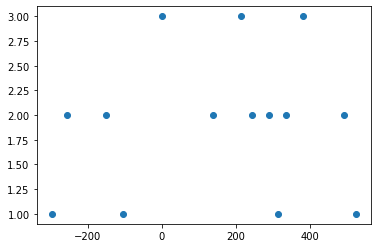

In [63]:
x_list=[]
y_list=[]
for key in new_list:
  #if key!=3:
  for ite in new_list[key]:
    if type(ite)==dict:
      #if ite["pos"][0]<600 and ite["pos"][0]>200:
      x_list.append(ite["pos"][0])
      y_list.append(ite["pos"][1])
    if type(ite)==list:
      for i in ite:
        x_list.append(i["pos"][0])
        y_list.append(i["pos"][1])

plt.scatter(x_list,y_list)


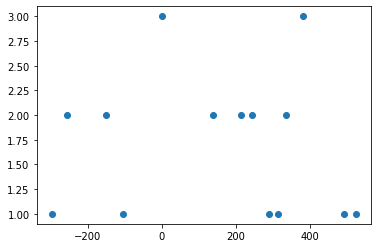

In [64]:
test={1: [{'av': 0, 'pos': [202.67886162850908, 1], 'speed': 139.31267260811532, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [236.23255420778491, 1], 'speed': 135.1332522657296, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [249.25849330030564, 1], 'speed': 128.2599585606223, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [298.55947888457877, 1], 'speed': 133.01023073526858, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [323.53830845085054, 1], 'speed': 130.44947264769937, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [350.8830242648957, 1], 'speed': 125.24745806838499, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [560.0931092113333, 1], 'speed': 123.40230357768515, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [565.897255704932, 1], 'speed': 123.49744342532429, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-111.94817168345548, 1], 'speed': 124.51992071116615, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-713.1242592434525, 1], 'speed': 123.69268363101409, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-724.5365122438017, 1], 'speed': 125.77048005718824, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-903.9653215575406, 1], 'speed': 133.27233513957069, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], 2: [{'av': 0, 'pos': [538.4820768620516, 2], 'speed': 130.93323165194843, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [557.0282573644002, 2], 'speed': 130.22800349416016, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [746.1059688477727, 2], 'speed': 122.63137978223955, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [941.2165417435098, 2], 'speed': 132.34540879616142, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [1090.2181290442902, 2], 'speed': 131.9702062696695, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [1170.659640580595, 2], 'speed': 133.26355435778203, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [1403.063665707306, 2], 'speed': 132.66624880089796, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [1460.3188137553288, 2], 'speed': 130.0021585506747, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-27.405783893994037, 2], 'speed': 128.7499462724667, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-148.7820826643822, 2], 'speed': 130.34362902429274, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-213.1191495086403, 2], 'speed': 129.9253067299706, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-363.39441913995387, 2], 'speed': 133.72237997297734, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], 3: [[{'av': 1, 'pos': [0.0, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], [{'av': 1, 'pos': [216.66666666666666, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], [{'av': 1, 'pos': [557.6538350454373, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [521.5427239343262, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [485.43161282321506, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], [{'av': 1, 'pos': [-244.91214969551044, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}]]}

x_list=[]
y_list=[]
for key in ntest:
  #if key!=3:
  for ite in ntest[key]:
    if type(ite)==dict:
      #if ite["pos"][0]<600 and ite["pos"][0]>200:
      x_list.append(ite["pos"][0])
      y_list.append(ite["pos"][1])
    if type(ite)==list:
      for i in ite:
        x_list.append(i["pos"][0])
        y_list.append(i["pos"][1])

plt.scatter(x_list,y_list)


In [ ]:
test={1: [{'av': 0, 'pos': [202.67886162850908, 1], 'speed': 139.31267260811532, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [236.23255420778491, 1], 'speed': 135.1332522657296, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [249.25849330030564, 1], 'speed': 128.2599585606223, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [298.55947888457877, 1], 'speed': 133.01023073526858, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [323.53830845085054, 1], 'speed': 130.44947264769937, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [350.8830242648957, 1], 'speed': 125.24745806838499, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [560.0931092113333, 1], 'speed': 123.40230357768515, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [565.897255704932, 1], 'speed': 123.49744342532429, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-111.94817168345548, 1], 'speed': 124.51992071116615, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-713.1242592434525, 1], 'speed': 123.69268363101409, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-724.5365122438017, 1], 'speed': 125.77048005718824, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-903.9653215575406, 1], 'speed': 133.27233513957069, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], 2: [{'av': 0, 'pos': [538.4820768620516, 2], 'speed': 130.93323165194843, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [557.0282573644002, 2], 'speed': 130.22800349416016, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [746.1059688477727, 2], 'speed': 122.63137978223955, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [941.2165417435098, 2], 'speed': 132.34540879616142, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [1090.2181290442902, 2], 'speed': 131.9702062696695, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [1170.659640580595, 2], 'speed': 133.26355435778203, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [1403.063665707306, 2], 'speed': 132.66624880089796, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [1460.3188137553288, 2], 'speed': 130.0021585506747, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-27.405783893994037, 2], 'speed': 128.7499462724667, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-148.7820826643822, 2], 'speed': 130.34362902429274, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-213.1191495086403, 2], 'speed': 129.9253067299706, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-363.39441913995387, 2], 'speed': 133.72237997297734, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], 3: [[{'av': 1, 'pos': [0.0, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], [{'av': 1, 'pos': [216.66666666666666, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], [{'av': 1, 'pos': [557.6538350454373, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [521.5427239343262, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [485.43161282321506, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], [{'av': 1, 'pos': [-244.91214969551044, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}]]}

def simulate_network(period=1, runs=1,plt_lane=[3],test=test):#,test1=copy.copy(test)):#,raw_veh_list=copy.copy(test)):
  #for ru in range(runs):
  vl=test
    #vl=initialization(av=1,ini_pos=[0,3],aggressive=False, route=1, lane_change=-1,lane_speed={1:100,2:120,3:130},plt_lane=[3], flow_rate=3000,av_rate=0.4, av_time_rate=0.9, max_plt_size=7, min_headway=1, plt_catchup_distance=100, forward=8, backward=4, min_inter_gap=5 )
  
  for pe in range(period):
    #qv=vl
    raw_veh_list=copy.deepcopy(vl)
    r={}
    for i in range
    for lane in raw_veh_list:
      r[lane]=len(raw_veh_list[lane]) 
    for lane in vl:
      print("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&"+str(lane))
      if not lane in plt_lane:
        if not len(vl[lane])==0:
          for v in range(r[lane]):
            if len(test[lane])!=r[lane]:
              a=True
              #print("???????????????????????????????????serious problem")
            temp_veh_list=copy.copy(raw_veh_list)
            print(r[lane])
            print(len(vl[lane]))
            print(v)
            #print(test)
            print(len(raw_veh_list[1]))
            print(len(raw_veh_list[2]))
            new_idx=vl[lane].index(raw_veh_list[lane][v])
            
            #vl[lane][new_idx]
            =lane_change_eval(veh=vl[lane][new_idx],veh_list=temp_veh_list,plt_lane=[3],lane_speed={1:120,2:120,3:130},lane_change_pos=500,min_lane_change_pos=100, interchange_len=400, exit_pos={1:1000,2:4000,3:7000})
  return vl

simulate_network()



In [ ]:
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(len(raw_veh_list[1]))
    print(len(raw_veh_list[2]))
  print("vl")
  print(vl)
  print("**********************************")
  print(len(vl[1]))
  print(len(vl[2]))

In [ ]:
a={1: [{'av': 0, 'pos': [202.67886162850908, 1], 'speed': 139.31267260811532, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [236.23255420778491, 1], 'speed': 135.1332522657296, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [249.25849330030564, 1], 'speed': 128.2599585606223, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [298.55947888457877, 1], 'speed': 133.01023073526858, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [323.53830845085054, 1], 'speed': 130.44947264769937, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [350.8830242648957, 1], 'speed': 125.24745806838499, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [560.0931092113333, 1], 'speed': 123.40230357768515, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [565.897255704932, 1], 'speed': 123.49744342532429, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-111.94817168345548, 1], 'speed': 124.51992071116615, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-713.1242592434525, 1], 'speed': 123.69268363101409, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-724.5365122438017, 1], 'speed': 125.77048005718824, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-903.9653215575406, 1], 'speed': 133.27233513957069, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], 2: [{'av': 0, 'pos': [538.4820768620516, 2], 'speed': 130.93323165194843, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [557.0282573644002, 2], 'speed': 130.22800349416016, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [746.1059688477727, 2], 'speed': 122.63137978223955, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [941.2165417435098, 2], 'speed': 132.34540879616142, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [1090.2181290442902, 2], 'speed': 131.9702062696695, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [1170.659640580595, 2], 'speed': 133.26355435778203, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [1403.063665707306, 2], 'speed': 132.66624880089796, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [1460.3188137553288, 2], 'speed': 130.0021585506747, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-27.405783893994037, 2], 'speed': 128.7499462724667, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-148.7820826643822, 2], 'speed': 130.34362902429274, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-213.1191495086403, 2], 'speed': 129.9253067299706, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-363.39441913995387, 2], 'speed': 133.72237997297734, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], 3: [[{'av': 1, 'pos': [0.0, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], [{'av': 1, 'pos': [216.66666666666666, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], [{'av': 1, 'pos': [557.6538350454373, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [521.5427239343262, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [485.43161282321506, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], [{'av': 1, 'pos': [-244.91214969551044, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}]]}
b={1: [{'av': 0, 'pos': [202.67886162850908, 1], 'speed': 139.31267260811532, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [236.23255420778491, 1], 'speed': 135.1332522657296, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [298.55947888457877, 1], 'speed': 133.01023073526858, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [350.8830242648957, 1], 'speed': 125.24745806838499, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [560.0931092113333, 1], 'speed': 123.40230357768515, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [565.897255704932, 1], 'speed': 123.49744342532429, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-111.94817168345548, 1], 'speed': 124.51992071116615, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-713.1242592434525, 1], 'speed': 123.69268363101409, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-724.5365122438017, 1], 'speed': 125.77048005718824, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [298.55947888457877, 1], 'speed': 133.01023073526858, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-724.5365122438017, 1], 'speed': 125.77048005718824, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-724.5365122438017, 1], 'speed': 125.77048005718824, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [746.1059688477727, 1], 'speed': 123.21562250552952, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [1090.2181290442902, 1], 'speed': 115.87470502700873, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [1403.063665707306, 1], 'speed': 121.43895029674346, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], 2: [{'av': 0, 'pos': [538.4820768620516, 2], 'speed': 130.93323165194843, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [557.0282573644002, 2], 'speed': 130.22800349416016, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [746.1059688477727, 1], 'speed': 123.21562250552952, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [1090.2181290442902, 1], 'speed': 115.87470502700873, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [1403.063665707306, 1], 'speed': 121.43895029674346, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-27.405783893994037, 2], 'speed': 128.7499462724667, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-148.7820826643822, 2], 'speed': 130.34362902429274, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-213.1191495086403, 2], 'speed': 129.9253067299706, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 0, 'pos': [-363.39441913995387, 2], 'speed': 133.72237997297734, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], 3: [[{'av': 1, 'pos': [0.0, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], [{'av': 1, 'pos': [216.66666666666666, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], [{'av': 1, 'pos': [557.6538350454373, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [521.5427239343262, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}, {'av': 1, 'pos': [485.43161282321506, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}], [{'av': 1, 'pos': [-244.91214969551044, 3], 'speed': 130, 'acceleration': 0, 'lane_change': 0, 'aggressive': False, 'route': 1}]]}

print(a==b)
print(len(a[1]))
print(len(a[2]))
print(len(b[1]))
print(len(b[2]))

In [ ]:

def platoon_leaving_eval(veh={'av': 1, 'pos': [0, 3], 'speed': 130.0, 'acceleration': 0, 'lane_change': -1, 'aggressive': False, 'route': 1},veh_list=vl,target_pos=1000,lane_change_pos=500,min_lane_change_pos=100, exit=[1000,3000,8000]):
  exit_mum=0
  target_pos=exit[exit_num]
  routing=veh["route"]
  x=veh["pos"][0]
  y=veh["pos"][1]
  if routing==0:
    pass
  elif routing==1:
    if target_pos-x<=lane_change_pos:
      if x>target_pos-min_lane_change_pos:
        print("exit missed")
        exit_num+=1
        target_pos=exit[exit_num]
        veh["route"]=0
      else:
        lc=gap_eval(veh=veh,nv_list=vl,plt_lane=[3],min_headway=1,lane_speed={1:120,2:120,3:130})
        if lc["right_change_possible"]==True:
          #lane_change(veh=veh, plt_lane=[3],lane_speed={1:120,2:120,3:130})
          new_veh_list=pop_from_platoon(veh_list=vl, veh=veh, plt_lane=[3])[0]
          new_veh=pop_from_platoon(veh_list=vl, veh=veh, plt_lane=[3])[0]
  



    

In [ ]:
t=[{"low":100, "high":120}, {"low":900, "high":20},{"low":35, "high":456}]
print(sorted(t, key = lambda i: i['low']))

In [ ]:
a=[1,2,3]
for k in a:
  if k==3:
    k=1
a

In [ ]:
l=[[1,2],[3,4]]
for n in l:
  for k in n:
    if k==2:
      n.pop(n.index(k))
l


In [ ]:
get_nei(veh=k[1],veh_list=k[0])

In [ ]:
k=0
fr=1000
sp=100
cud=0.1 #catchup d in km
for s in range(1,1000):
  #print(1-math.exp(-fr*cud/sp))
  k+=((1-math.exp(-fr*cud/sp))**(s-1))*math.exp(-fr*cud/sp)
print(k)

In [ ]:
lst=[[1,2,3],[4,5,6]]
#lst.pop([4,5,6])
#lst
idx=lst.index([1,2,3])
lst.pop(idx)
lst

In [ ]:
min({1:2,3:6,7:0})



In [ ]:
np.random.exponential(1/1000)*120*1000

In [ ]:
for v in nei_dic[key][a][0][0]:
            #print(v["pos"])
            x_list.append(v["pos"][0])
            y_list.append(v["pos"][1])
            #key 0,1,-1; a fbc; v
        else:
          #for v in nei_dic[key]:
          x_list.append(nei_dic[key][a][0]["pos"][0])
          y_list.append(nei_dic[key][a][0]["pos"][1])
